In [45]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from scipy.spatial.distance import cdist
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

### How can I identify similar Marathon performances?

In [46]:
df = pd.read_csv('results.csv')
df.head()

,10k,name,division,25k,gender,age,official,bib,genderdiv,ctz,...,overall,pace,state,30k,5k,half,20k,country,city,40k
0,17.37,"Yamamoto, Hiroyuki",8,47.67,M,47,85.25,W1,8,NaN,...,8,3.27,NaN,59.18,8.02,39.72,37.65,JPN,Fukuoka,80.43
1,32.58,"Jeptoo, Rita",1,82.43,F,33,138.95,F1,1,NaN,...,21,5.30,NaN,99.33,16.22,69.47,65.83,KEN,Eldoret,132.10
2,16.62,"Van Dyk, Ernst F.",1,45.80,M,41,80.60,W2,1,NaN,...,1,3.08,NaN,56.45,7.75,38.03,36.10,RSA,Paarl,76.10
3,32.57,"Dibaba, Mare",3,82.43,F,24,140.58,F2,3,NaN,...,27,5.37,NaN,99.33,16.20,69.47,65.83,ETH,Shoa,132.95
4,17.12,"Hokinoue, Kota",2,46.37,M,40,81.23,W3,2,NaN,...,2,3.10,NaN,57.03,8.02,38.60,36.58,JPN,Nogata Fukuoka,76.72


In [47]:
# Data Cleaning

# Drop ctz and state column
df = df.drop(['ctz', 'state'], 1)

# Drop row in city where there's a null value
df = df.dropna(subset=['city'])

# Replace values that represent null
df = df.replace('-', np.nan)

# Convert types to numeric
df[['10k', '25k', '35k', '30k', '5k', 'half', '20k', '40k']] = df[['10k', '25k', '35k', '30k', '5k', 'half', '20k', '40k']].apply(pd.to_numeric)

# Impute null with means
df = df.fillna(df.mean())

# Create features
features = df.drop(['city', 'division', 'name','bib', 'overall', 'country', 'genderdiv'], 1)

# Make categorical variables numeric using label encoder
labelencoder = LabelEncoder()
labelencoder.fit(features['gender'])
features['gender'] = labelencoder.transform(features['gender'])

In [48]:
features.head()

,10k,25k,gender,age,official,35k,pace,30k,5k,half,20k,40k
0,17.37,47.67,1,47,85.25,71.40,3.27,59.18,8.02,39.72,37.65,80.43
1,32.58,82.43,0,33,138.95,116.37,5.30,99.33,16.22,69.47,65.83,132.10
2,16.62,45.80,1,41,80.60,67.42,3.08,56.45,7.75,38.03,36.10,76.10
3,32.57,82.43,0,24,140.58,116.37,5.37,99.33,16.20,69.47,65.83,132.95
4,17.12,46.37,1,40,81.23,67.83,3.10,57.03,8.02,38.60,36.58,76.72


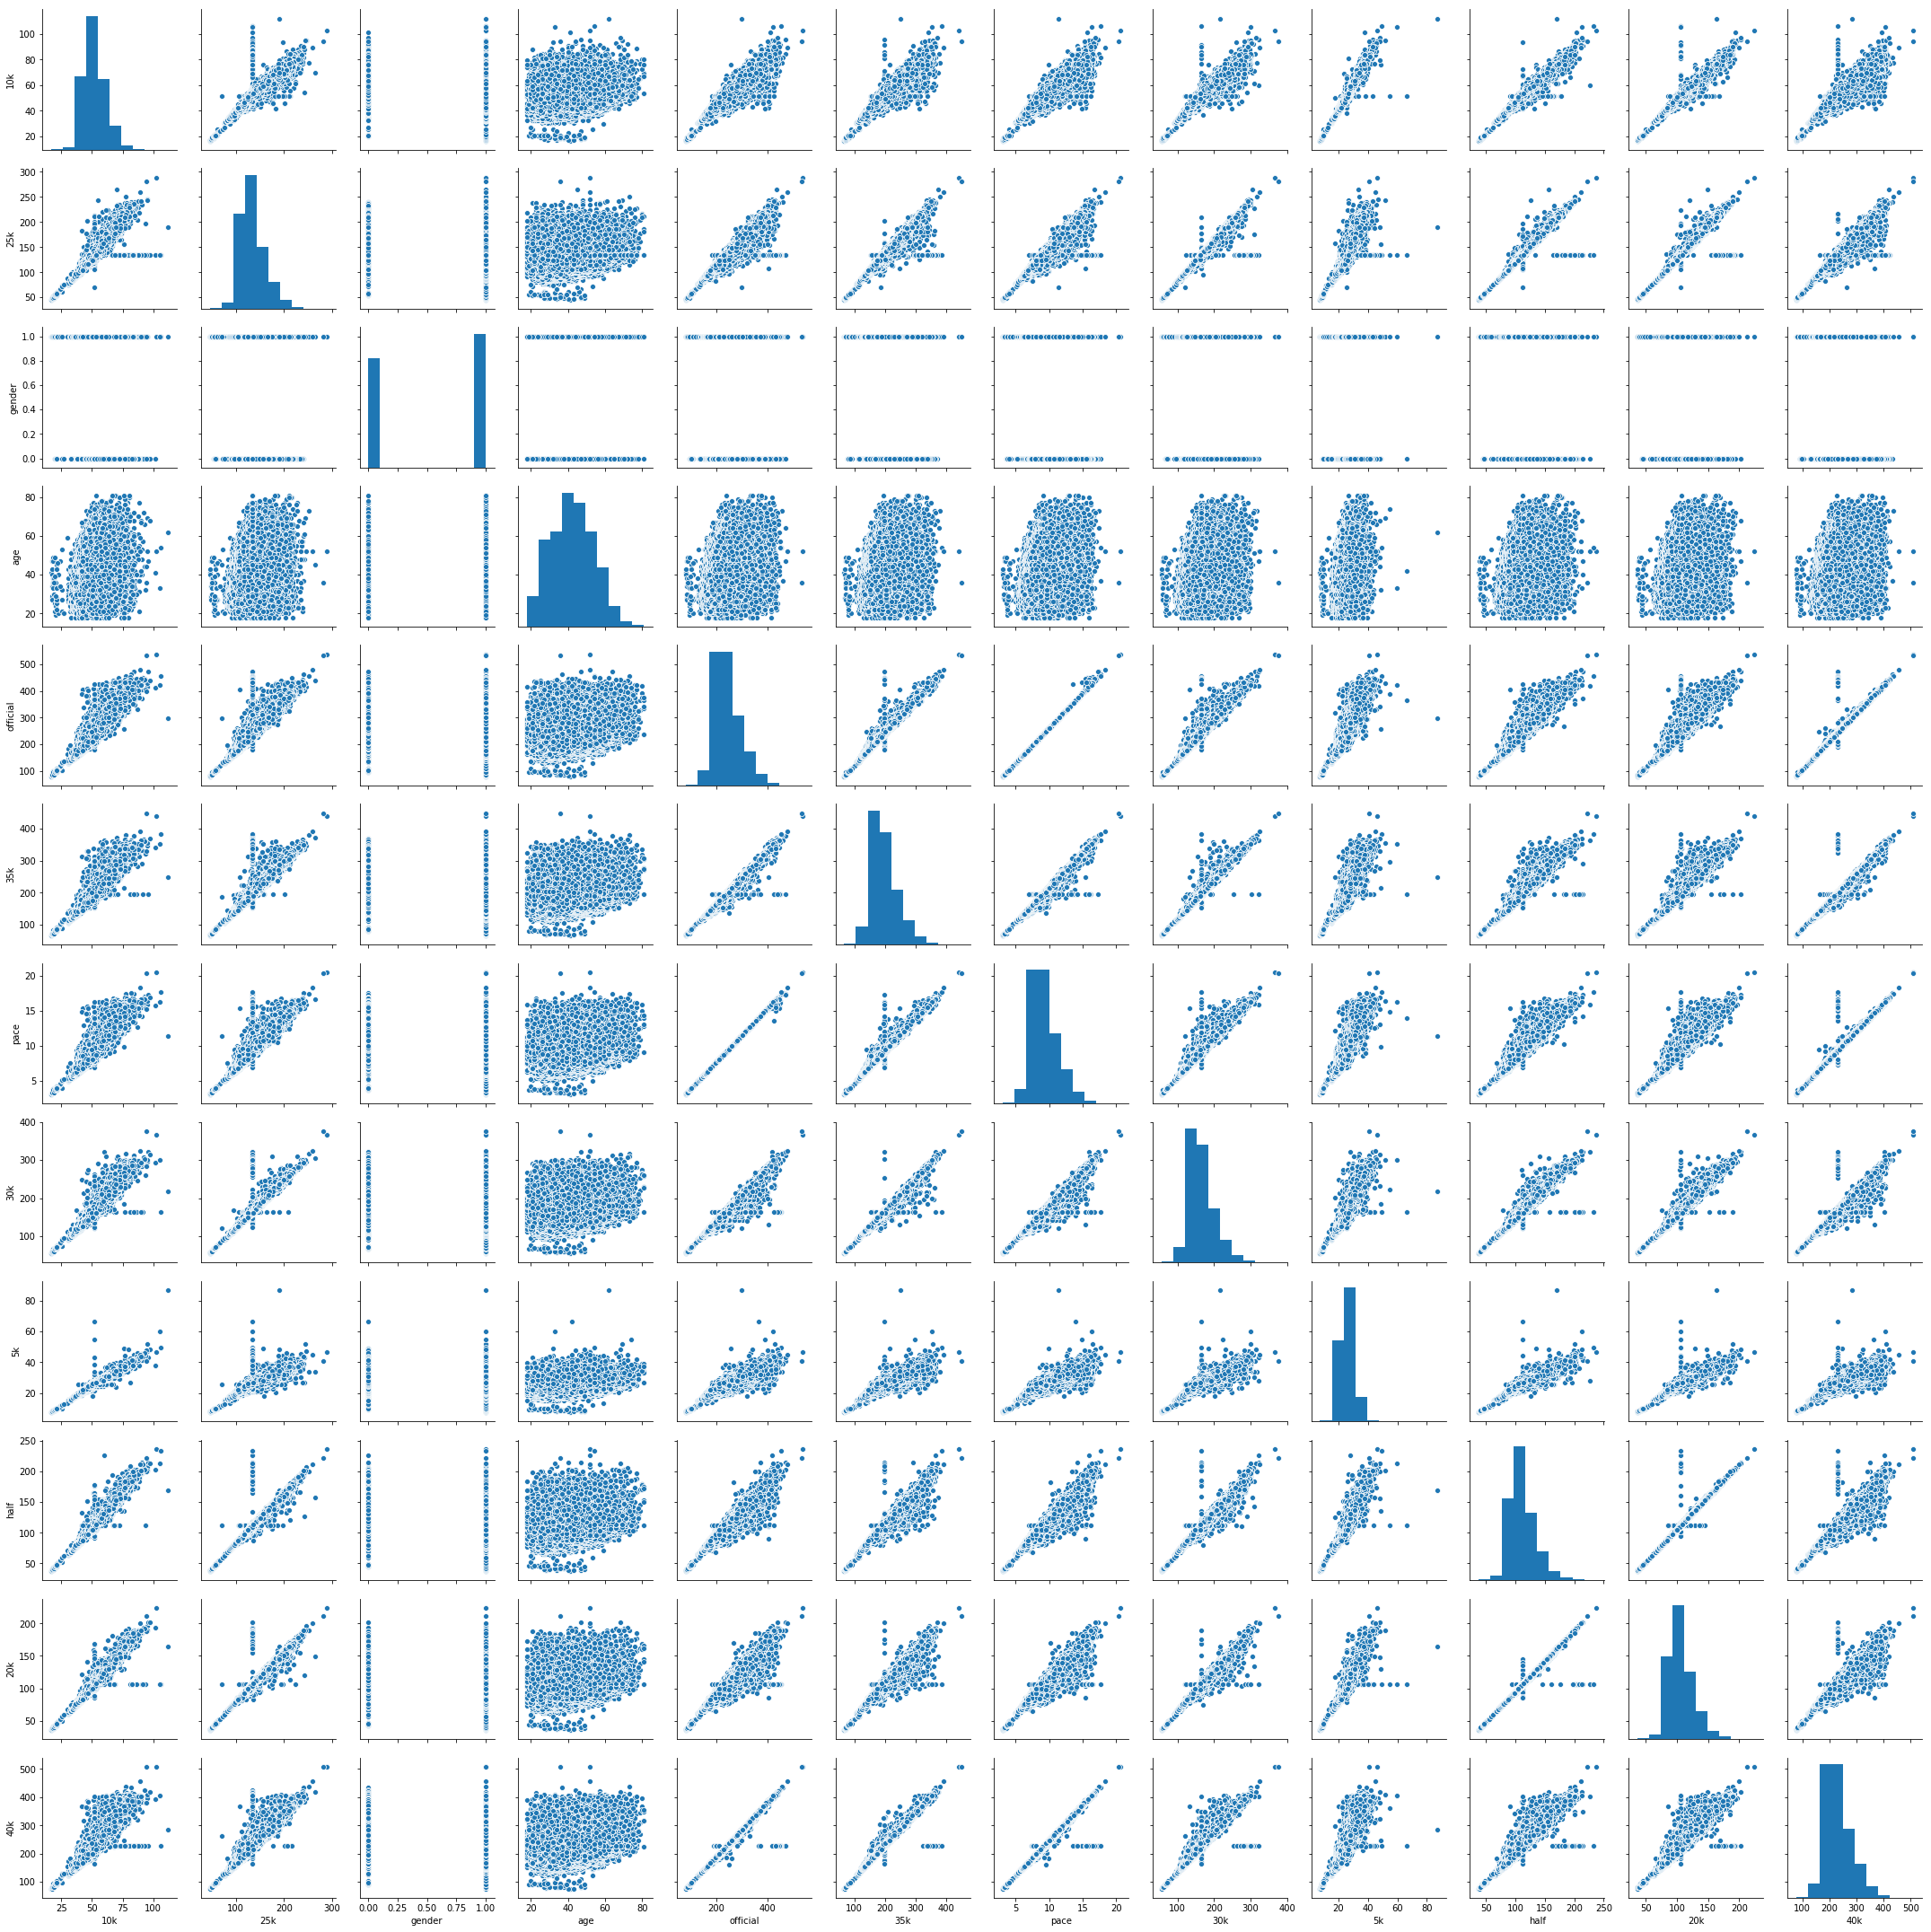

In [31]:
sns.pairplot(features)

In [49]:
# Break into a set of features and a variable for the known outcome.
X = features.iloc[:, :12]
y = features.iloc[:, 11]

In [50]:
# Create training set of 10% of the data
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.9, random_state=42)
x_train

# Create 2 component PCAs
pca = PCA(n_components = 2)
x_train['X'] = pca.fit_transform(x_train.drop(columns=['gender', 'age']))[:,0]
x_train['Y'] = pca.fit_transform(x_train.drop(columns=['gender', 'age']))[:,1]
x_train = x_train.reset_index()
X_pca = x_train[['age', 'X', 'Y']]

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [51]:
X_pca.head()

,age,X,Y
0,51,82.561963,2.672195
1,44,103.660226,-8.966813
2,38,-39.734221,11.389627
3,23,-37.705921,-0.766649
4,53,231.703196,2.270587


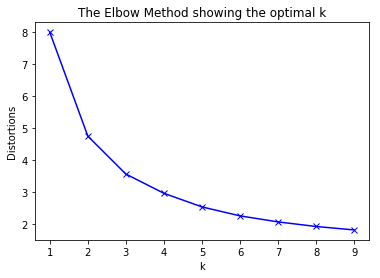

In [52]:
# Determine K by creating elbow curve

# Create list of distortions for each K value
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(X_pca)
    kmeanModel.fit(X_pca)
    distortions.append(sum(np.min(cdist(X_pca, kmeanModel.cluster_centers_, 'euclidean'), axis=1))/ X.shape[0])
    
# plot the Elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortions')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [67]:
# Break into a set of features
X = X_pca.iloc[:, :3]

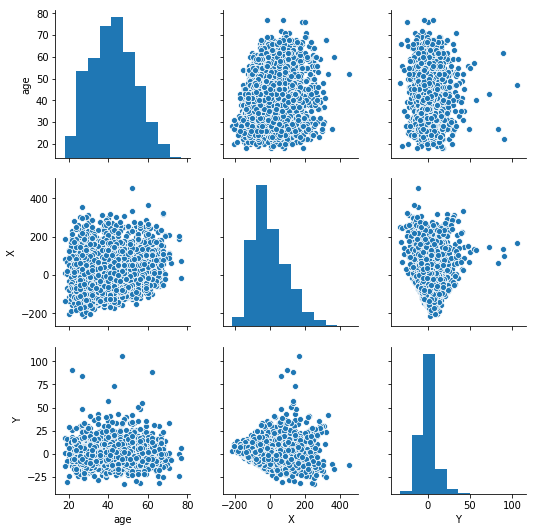

In [68]:
sns.pairplot(X)

In [69]:
# Create n-dimensional array of training data X
X = X.values

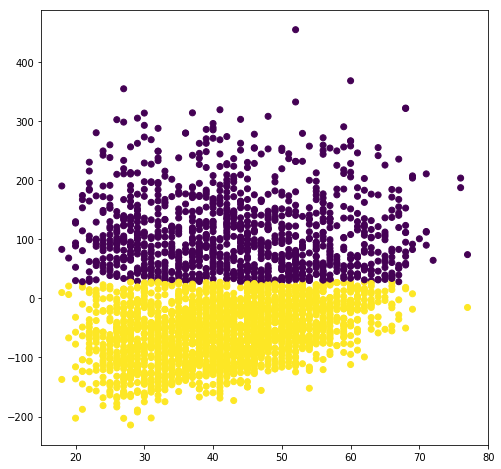

In [76]:
# Instantiate KMeans Cluster Algorithm
prediction = KMeans(n_clusters=2, random_state=42).fit_predict(X_pca)

# Visualize clusters from PCAs
plt.figure(figsize=(8,8))
plt.scatter(X[:,0], X[:,1], c = prediction)
plt.show()

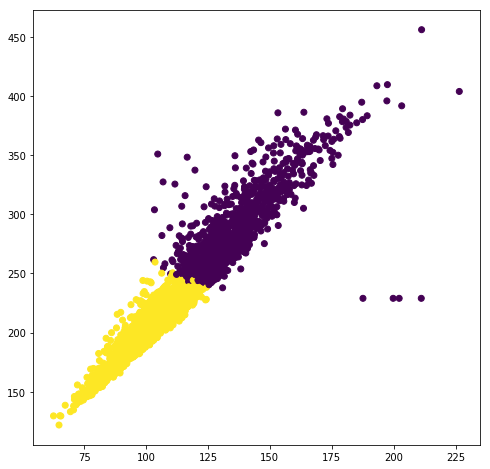

In [77]:
# Visualize clusters from PCAs
plt.figure(figsize=(8,8))
plt.scatter(x_train['half'], x_train['40k'], c = prediction)
plt.show()

In [78]:
from sklearn.cluster import MeanShift, estimate_bandwidth

# Here we set the bandwidth. This function automatically derives a bandwidth
# number based on an inspection of the distances among points in the data.
bandwidth = estimate_bandwidth(X_pca, quantile=0.2, n_samples=500)

# Declare and fit the model.
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X_pca)

# Extract cluster assignments for each data point.
labels = ms.labels_

# Coordinates of the cluster centers.
cluster_centers = ms.cluster_centers_

# Count our clusters.
n_clusters_ = len(np.unique(labels))

print("Number of estimated clusters: {}".format(n_clusters_))

Number of estimated clusters: 3


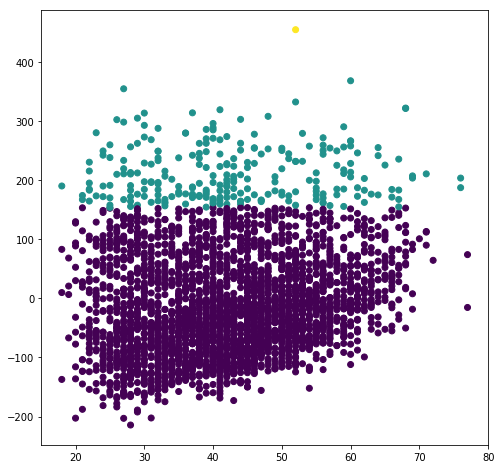

In [75]:
plt.figure(figsize=(8,8))
plt.scatter(X[:,0], X[:,1], c = labels)
plt.show()

- Evaluate the clusters
- Do Exploratory Data Analysis to investigate relationships in data
- Indentify possible prediction variables based on exploratory data analysis
- Use K-means to predict labels and evaluate accuracy via cross-tab
- Create visualizations clusters and relationships that correspond with your prediction
- Describe findings in a report